## Tic-Tac-Toe Agent

The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values
        
MDP for Numerical Tic-Tac-Toe game.
* +10 if the agent wins (makes 15 points first)
* -10 if the environment wins
* 0 if the game ends in a draw (no one is able to make 15 and the board is filled up)
* -1 for each move agent takes

step function which takes in an input of the agent’s action and state; and outputs the next state and reward.

Q-values convergence- check whether Q-values learnt by the agent have converged or not. Sample 4 state-action pairs and plot it with the number of episodes to understand the convergence.

#### Importing libraries
importing Tic-Tac-Toe class from the environment file

In [1]:
# importing  TicTacToe class from environment file
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

from itertools import groupby
from itertools import product

In [2]:
class TicTacToe():

    def __init__(self):
        """initialise the board"""
        
        # initialise state as an array
        self.state = [np.nan for _ in range(9)]  # initialises the board position, can initialise to an array or matrix
        # all possible numbers
        self.all_possible_numbers = [i for i in range(1, len(self.state) + 1)] # , can initialise to an array or matrix
        # set all members to their initial value
        self.reset()

    def is_winning(self, curr_state):
        """Takes state as an input and returns whether any row, column or diagonal has winning sum
        Example: Input state- [1, 2, 3, 4, nan, nan, nan, nan, nan]
        Output = False"""
        winning_index = [(0,1,2),(3,4,5),(6,7,8),(0,3,6),(1,4,7),(2,5,8),(0,4,8),(2,4,6)]

        for idx in winning_index:
            # check row/column is filled up
            if np.isnan([curr_state[idx[0]],curr_state[idx[1]],curr_state[idx[2]]]).sum() == 0:
                # check total sum equal to 15
                if np.sum([curr_state[idx[0]],curr_state[idx[1]],curr_state[idx[2]]]) == 15:
                    return True
        
        return False
 
    def is_terminal(self, curr_state):
        # Terminal state could be winning state or when the board is filled up
        if self.is_winning(curr_state) == True:
            return True, 'Win'
        elif len(self.allowed_positions(curr_state)) ==0:
            return True, 'Tie'
        else:
            return False, 'Resume'

    def allowed_positions(self, curr_state):
        """Takes state as an input and returns all indexes that are blank"""
        return [i for i, val in enumerate(curr_state) if np.isnan(val)]

    def allowed_values(self, curr_state):
        """Takes the current state as input and returns all possible (unused) values that can be placed on the board"""

        used_values = [val for val in curr_state if not np.isnan(val)]
        agent_values = [val for val in self.all_possible_numbers if val not in used_values and val % 2 !=0]
        env_values = [val for val in self.all_possible_numbers if val not in used_values and val % 2 ==0]

        return (agent_values, env_values)

    def action_space(self, curr_state):
        """Takes the current state as input and returns all possible actions, i.e, all combinations of allowed positions and allowed values"""

        agent_actions = product(self.allowed_positions(curr_state), self.allowed_values(curr_state)[0])
        env_actions = product(self.allowed_positions(curr_state), self.allowed_values(curr_state)[1])
        return (agent_actions, env_actions)

    def state_transition(self, curr_state, curr_action):
        """Takes current state and action and returns the board position just after agent's move.
        Example: Input state- [1, 2, 3, 4, nan, nan, nan, nan, nan], action- [7, 9] or [position, value]
        Output = [1, 2, 3, 4, nan, nan, nan, 9, nan]
        """
        curr_state[curr_action[0]] = curr_action[1]
        return curr_state


    def step(self, curr_state, curr_action):
        """Takes current state and action and returns the next state, reward and whether the state is terminal. Hint: First, check the board position after
        agent's move, whether the game is won/loss/tied. Then incorporate environment's move and again check the board status.
        Example: Input state- [1, 2, 3, 4, nan, nan, nan, nan, nan], action- [7, 9] or [position, value]
        Output = ([1, 2, 3, 4, nan, nan, nan, 9, nan], -1, False)"""
        
        next_state = self.state_transition(curr_state, curr_action)
        terminal, result = self.is_terminal(next_state)
        
        if terminal == True:
            if (result == 'Win'):
            # Agent has won reward of 10
                reward = 10
                result = "Agent_won"
            elif (result == 'Tie'):
            # Game turned to Tie reward of 0
                reward = 0
                
            return next_state,reward,terminal,result
        
        else:
            # result is 'Resume' perform Environment move
            _, envn_actions = self.action_space(next_state)
            # pick a random action in available move
            envn_act = random.choice(list(envn_actions))
            next_state = self.state_transition(next_state, envn_act)
            
            # Check for the results
            terminal, result = self.is_terminal(next_state)
            
            if terminal == True:
                #Game has completed
                if (result == 'Win'):
                    # Envinorment has won reward of -10
                    reward = -10
                    result = "Envn_won"
                elif (result == 'Tie'):
                # Game turned to Tie reward of 0
                    reward = 0
            else :
                # Game needs to resume
                # reward of -1 to staying in 
                reward = -1
            
            return next_state,reward,terminal,result

    def reset(self):
        return self.state

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):

    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
print("Making sure envinorment and Q_state are initialing \n")
# initializing Tictactoe object from the environment file
envn = TicTacToe()
print(envn.state)
print(Q_state(envn.state))

Making sure envinorment and Q_state are initialing 

[nan, nan, nan, nan, nan, nan, nan, nan, nan]
x-x-x-x-x-x-x-x-x


In [5]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    # calling action_space to get all possible actions
    valid_Actions = [i for i in envn.action_space(state)[0]]
    return valid_Actions

In [6]:
print("Valid action for State:- ",Q_state(envn.state),"\n")
print(valid_actions(envn.state))

Valid action for State:-  x-x-x-x-x-x-x-x-x 

[(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (1, 1), (1, 3), (1, 5), (1, 7), (1, 9), (2, 1), (2, 3), (2, 5), (2, 7), (2, 9), (3, 1), (3, 3), (3, 5), (3, 7), (3, 9), (4, 1), (4, 3), (4, 5), (4, 7), (4, 9), (5, 1), (5, 3), (5, 5), (5, 7), (5, 9), (6, 1), (6, 3), (6, 5), (6, 7), (6, 9), (7, 1), (7, 3), (7, 5), (7, 7), (7, 9), (8, 1), (8, 3), (8, 5), (8, 7), (8, 9)]


In [7]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

### Epsilon-greedy strategy Funchion

In [8]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    # Generate random float number between 0 to 1 
    z = np.random.random()
    if z > epsilon:
        # ===> Pick the action having maximum reward
        act_state = Q_state(state)
        action = max(Q_dict[act_state],key=Q_dict[act_state].get)
    else:
        # ===> random action generation
        action = random.sample(valid_actions(state),1)[0]
    return action


### For Tracking the state-action pairs for checking the Convergence 

In [67]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track =collections.defaultdict(dict)

In [68]:
# Initialise states to be tracked
def initialise_tracking_states():
    Sample_Qvalues = [('x-3-x-x-x-6-x-x-x',(0,1)),
                       ('x-1-x-x-x-x-8-x-x',(2,9)),
                       ('x-x-x-x-6-x-x-x-5',(2,7)),
                       ('x-x-x-x-9-x-6-x-x',(1,7)),
                       ('x-5-x-2-x-x-4-7-x',(0,9)),
                       ('9-x-5-x-x-x-8-x-4',(1,3)),
                       ('2-7-x-x-6-x-x-3-x',(8,5)),
                       ('9-x-x-x-x-2-x-x-x',(2,5)),
                       ('x-x-7-x-x-x-x-x-2',(1,5)),
                       ('5-x-x-x-x-6-x-x-x',(4,9)),
                       ('4-x-x-6-x-x-3-1-x',(8,5)),
                       ('5-x-8-x-x-6-3-x-x',(3,1)),
                       ('x-6-5-x-2-x-x-3-x',(0,7)),
                       ('7-x-5-x-2-x-x-x-6',(1,3))]    #selecting some 4 Q-values
    for q_values in Sample_Qvalues:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

initialise_tracking_states()

In [69]:
print("State_track default state:- \n")
States_track

State_track default state:- 



defaultdict(dict,
            {'2-7-x-x-6-x-x-3-x': {(8, 5): []},
             '4-x-x-6-x-x-3-1-x': {(8, 5): []},
             '5-x-8-x-x-6-3-x-x': {(3, 1): []},
             '5-x-x-x-x-6-x-x-x': {(4, 9): []},
             '7-x-5-x-2-x-x-x-6': {(1, 3): []},
             '9-x-5-x-x-x-8-x-4': {(1, 3): []},
             '9-x-x-x-x-2-x-x-x': {(2, 5): []},
             'x-1-x-x-x-x-8-x-x': {(2, 9): []},
             'x-3-x-x-x-6-x-x-x': {(0, 1): []},
             'x-5-x-2-x-x-4-7-x': {(0, 9): []},
             'x-6-5-x-2-x-x-3-x': {(0, 7): []},
             'x-x-7-x-x-x-x-x-2': {(1, 5): []},
             'x-x-x-x-6-x-x-x-5': {(2, 7): []},
             'x-x-x-x-9-x-6-x-x': {(1, 7): []}})

In [70]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [71]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

### Model Hyperparameters

In [76]:
#Defining parameters for the training

EPISODES = 5000000         # Number of training episodes

LR = 0.2                   # learning rate
GAMMA = 0.8                # discount factor

max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.000001       # epsilon decay rate
threshold = 2000            # no of episodes after which states_tracked wwill be saved

chkpt_print = int(EPISODES/10) # Print debug log while training

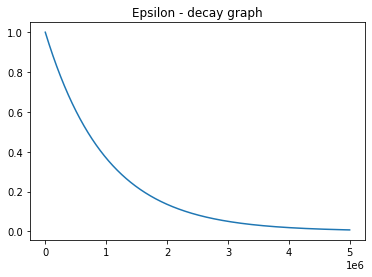

In [77]:
episd = np.arange(0,EPISODES)
epsilon = []
for i in range(0,EPISODES):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*i))

plt.plot(episd, epsilon)
plt.title("Epsilon - decay graph")
plt.show()

### Q-update loop

In [78]:
start_time = time.time()
episode_time= time.time()
agent_won = 0
envn_won = 0
tie_cnt = 0
total_reward = 0
    
for episode in range(EPISODES):
    # initializing the object for new episode
    
    env = TicTacToe()
    curr_state = env.state
    isTerminated = False
    add_to_dict(curr_state)
    
    while not isTerminated:
        current_lookup = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        next_state, reward, isTerminated,result = env.step(curr_state, curr_action)

        if isTerminated:
            # Game terminated
            if result == "Agent_won":
                agent_won += 1
            elif result == "Envn_won":
                envn_won += 1
            else :
                tie_cnt += 1
            # update Q table with new reward
            Q_dict[current_lookup][curr_action] += LR*((reward - Q_dict[current_lookup][curr_action]))
        else:
            # Game has to be resume
            next_lookup = Q_state(next_state)
            add_to_dict(next_state)
            # select the action having max reward
            max_next = max(Q_dict[next_lookup],key=Q_dict[next_lookup].get)
            # update Q table 
            Q_dict[current_lookup][curr_action] += \
              LR *((reward + (GAMMA * (Q_dict[next_lookup][max_next]))) -\
              Q_dict[current_lookup][curr_action])
        
        # update the Current state
        curr_state = next_state
        total_reward += reward

    # for debug logs
    if (episode + 1) % chkpt_print == 0:
        print("After %d Episodes:- Agent Won: %.3f%%, Environment Won: %.3f%%, Tie: %.3f%%, T-Reward: %d, Time: %ds"% \
          (episode + 1, agent_won / (chkpt_print - 1), envn_won /(chkpt_print - 1), tie_cnt / (chkpt_print - 1),\
           total_reward,time.time()-episode_time))
        episode_time = time.time()
        total_reward = 0
        agent_won = 0
        envn_won = 0
        tie_cnt = 0
    
    # Save state-action pairs
    if ((episode+1) % threshold) == 0:   #every 2000th episode
        save_tracking_states()


elapsed_time = time.time() - start_time
save_obj(States_track, 'States_tracked')
save_obj(Q_dict, 'Policy')
print("Total time:- ",elapsed_time)


After 500000 Episodes:- Agent Won: 0.278%, Environment Won: 0.272%, Tie: 0.449%, T-Reward: -1633885, Time: 678s
After 1000000 Episodes:- Agent Won: 0.470%, Environment Won: 0.202%, Tie: 0.329%, T-Reward: -156159, Time: 573s
After 1500000 Episodes:- Agent Won: 0.663%, Environment Won: 0.134%, Tie: 0.203%, T-Reward: 1315434, Time: 485s
After 2000000 Episodes:- Agent Won: 0.785%, Environment Won: 0.087%, Tie: 0.128%, T-Reward: 2248283, Time: 447s
After 2500000 Episodes:- Agent Won: 0.851%, Environment Won: 0.060%, Tie: 0.089%, T-Reward: 2764360, Time: 419s
After 3000000 Episodes:- Agent Won: 0.883%, Environment Won: 0.041%, Tie: 0.076%, T-Reward: 3020914, Time: 409s
After 3500000 Episodes:- Agent Won: 0.901%, Environment Won: 0.029%, Tie: 0.070%, T-Reward: 3152254, Time: 407s
After 4000000 Episodes:- Agent Won: 0.919%, Environment Won: 0.021%, Tie: 0.060%, T-Reward: 3283061, Time: 407s
After 4500000 Episodes:- Agent Won: 0.929%, Environment Won: 0.016%, Tie: 0.055%, T-Reward: 3356335, Tim

### Q-dictionary

In [79]:
# to load pickle files
with open('States_tracked.pkl', 'rb') as f:
    States_track = pickle.load(f)

with open('Policy.pkl', 'rb') as f:
    Q_dict = pickle.load(f)

In [80]:
print("Number of enteries in Q table :- %d"%len(Q_dict))

Number of enteries in Q table :- 1296500


In [81]:
state = 'x-3-x-x-x-6-x-x-x' 
print("Checking Entries for %s state\n"%state)
Q_dict[state]

Checking Entries for x-3-x-x-x-6-x-x-x state



{(0, 1): -0.8208575583289344,
 (0, 5): -0.03169561719241412,
 (0, 7): 6.601600704163662,
 (0, 9): -0.2909949023289342,
 (2, 1): -0.9141006540800001,
 (2, 5): -1.0546062718009341,
 (2, 7): -0.15048052326399997,
 (2, 9): -0.9237949106631476,
 (3, 1): -0.931280523264,
 (3, 5): -0.3152403221448692,
 (3, 7): -1.5117050879999998,
 (3, 9): -0.9450244186112,
 (4, 1): -0.9116925023289343,
 (4, 5): -0.931280523264,
 (4, 7): -0.9141006540800001,
 (4, 9): -0.865782272,
 (6, 1): -0.9258244186112,
 (6, 5): -0.865782272,
 (6, 7): -0.9450244186112,
 (6, 9): -0.8582013296640001,
 (7, 1): -0.777185601490518,
 (7, 5): -0.8828493015308554,
 (7, 7): -0.920051956182155,
 (7, 9): -0.8926258176,
 (8, 1): -2.395578984071168,
 (8, 5): -0.9757580811924144,
 (8, 7): -0.865782272,
 (8, 9): -0.865782272}

In [82]:
next_action = max(Q_dict[state],key=Q_dict[state].get)
print("Best action for state %s is %s" % (state,str(next_action)))
print("Q(s,a) is ",Q_dict[state][next_action])

Best action for state x-3-x-x-x-6-x-x-x is (0, 7)
Q(s,a) is  6.601600704163662


### States tracked for Q-values convergence

<function matplotlib.pyplot.show>

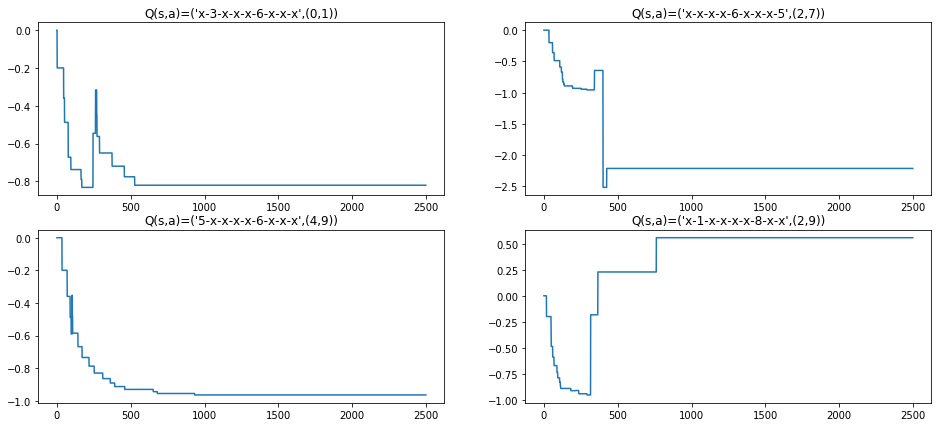

In [84]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track['x-3-x-x-x-6-x-x-x'][(0,1)])))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track['x-3-x-x-x-6-x-x-x'][(0,1)]))
plt.title("Q(s,a)=('x-3-x-x-x-6-x-x-x',(0,1))")
plt.show

x_axis = np.asarray(range(0, len(States_track['x-x-x-x-6-x-x-x-5'][(2,7)])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track['x-x-x-x-6-x-x-x-5'][(2,7)]))
plt.title("Q(s,a)=('x-x-x-x-6-x-x-x-5',(2,7))")
plt.show

x_axis = np.asarray(range(0, len(States_track['5-x-x-x-x-6-x-x-x'][(4,9)])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track['5-x-x-x-x-6-x-x-x'][(4,9)]))
plt.title("Q(s,a)=('5-x-x-x-x-6-x-x-x',(4,9))")
plt.show

x_axis = np.asarray(range(0, len(States_track['x-1-x-x-x-x-8-x-x'][(2,9)])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track['x-1-x-x-x-x-8-x-x'][(2,9)]))
plt.title("Q(s,a)=('x-1-x-x-x-x-8-x-x',(2,9))")
plt.show